# DTI Network: Drug-Target Interaction with DGL Life Science and Hugging Face

In [ ]:
!conda install -y pytorch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0 cudatoolkit=10.2 -c pytorch
!conda install -y -c dglteam dgl-cuda10.2
!conda install -y -c conda-forge rdkit==2018.09.3
!conda install -y -c dglteam dgllife
!pip install pytdc
!pip install transformers
!pip install d2l

## Generic Imports

In [1]:
import os
import sys
import shutil
import re
import random
import time
import json
import glob
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from pprint import pprint
from datetime import datetime

# Plotting
sns.set_theme(style='ticks')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# S3 Client
import boto3

region = boto3.Session().region_name
s3_client = boto3.client('s3')

# SageMaker
import sagemaker

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

# Multiprocessing
import multiprocessing

num_workers = multiprocessing.cpu_count()

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


device(type='cuda')

## Load benchmark data with PyTDC

In [22]:
from tdc.multi_pred import DTI

data = DTI(name = 'DAVIS')
data.convert_to_log(form = 'binding')

# data = DTI(name = 'KIBA')

# data = DTI(name = 'BindingDB_IC50')
# data.harmonize_affinities(mode = 'max_affinity')
# data.convert_to_log(form = 'binding')

split = data.get_split()

Found local copy...
Loading...
Done!
To log space...


In [23]:
train_data = split["train"]
valid_data = split["valid"]
test_data = split["test"]

In [24]:
prot_lens = pd.Series([len(x) for x in train_data.Target.tolist()])
prot_lens.describe()

count    18041.000000
mean       747.923785
std        376.172691
min        244.000000
25%        478.000000
50%        635.000000
75%        961.000000
max       2549.000000
dtype: float64

<AxesSubplot:>

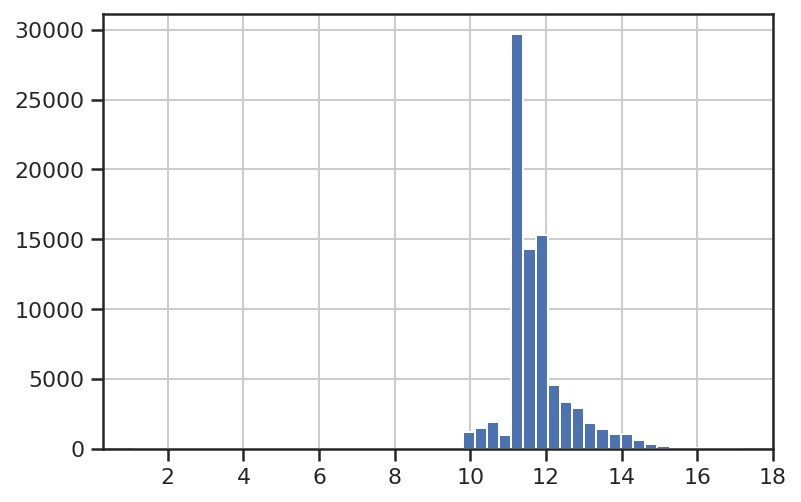

In [15]:
train_data.Y.hist(bins=50)

In [7]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

target_scaler = MinMaxScaler()
# target_scaler = FunctionTransformer(lambda x: x)
train_data.Y = target_scaler.fit_transform(train_data.Y.values.reshape(-1, 1))

<AxesSubplot:>

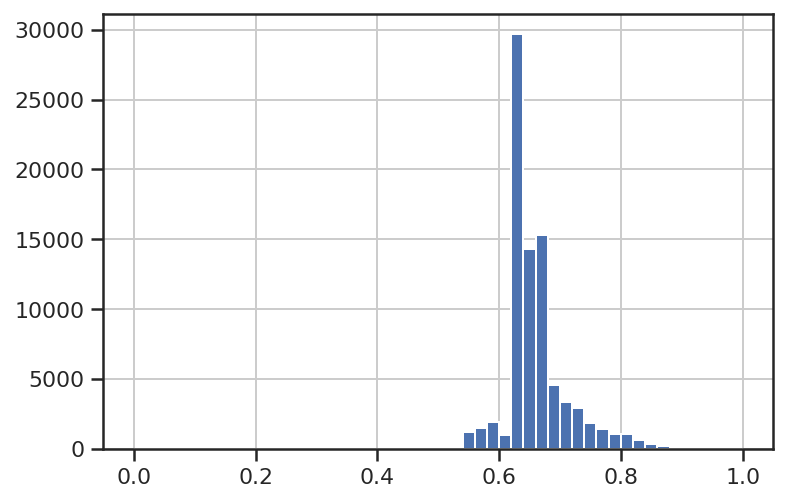

In [8]:
train_data.Y.hist(bins=50)

In [9]:
len(train_data), len(valid_data), len(test_data)

(82360, 11766, 23531)

## DTI Models

Goal: better version of https://www.biorxiv.org/content/10.1101/684662v8.full

In [10]:
from transformers import BertModel, BertTokenizer
from dgllife.utils import AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer, smiles_to_bigraph
from dgllife.utils import PretrainAtomFeaturizer, PretrainBondFeaturizer

In [11]:
class DTIDataset(Dataset):
    def __init__(self, drugs, targets, affinities):
        self.drugs = drugs
        self.targets = targets
        self.affinities = affinities
        self.atom_featurizer = AttentiveFPAtomFeaturizer()
        self.bond_featurizer = AttentiveFPBondFeaturizer()

    def __len__(self):
        return len(self.affinities)

    def __getitem__(self, idx):
        smiles = self.drugs[idx]
        mol_graph = smiles_to_bigraph(smiles, 
                                      node_featurizer=self.atom_featurizer, 
                                      edge_featurizer=self.bond_featurizer,
                                      )
        sequence = self.targets[idx]
        temp = [l for l in sequence]
        temp = " ".join(temp)
        temp = re.sub(r"[UZOB]", "X", temp)
        label = self.affinities[idx]
        return mol_graph, temp, label

In [12]:
import dgl
from torch.utils.data._utils.collate import default_collate

def collate_fn(batch):
    mol_graphs, protein_sequences, labels = tuple(zip(*batch))
    return dgl.batch(mol_graphs), default_collate(protein_sequences), default_collate(labels) 

In [13]:
# Create dataset and dataloader from PyTDC 
train_drugs = train_data.Drug.tolist()
train_targets = train_data.Target.tolist()
train_affinities = train_data.Y.tolist()
train_dataset = DTIDataset(train_drugs, train_targets, train_affinities)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [14]:
# Create dataset and dataloader from PyTDC 
valid_drugs = valid_data.Drug.tolist()
valid_targets = valid_data.Target.tolist()
valid_affinities = valid_data.Y.tolist()
valid_dataset = DTIDataset(valid_drugs, valid_targets, valid_affinities)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [15]:
# Extract node and edge dimensionality from molecular graphs
mol_graphs, protein_sequences, labels = next(iter(train_dataloader))
mol_node_dim = mol_graphs.ndata['h'].shape[1]
mol_edge_dim = mol_graphs.edata['e'].shape[1]

In [16]:
from dgllife.model import AttentiveFPGNN, AttentiveFPReadout
from d2l import torch as d2l
from torch.nn.utils.rnn import pad_sequence

# Adapted from Mufei's DGL Life Science example
class AttentiveFPEmbedding(nn.Module):
    def __init__(self,
                 node_feat_size,
                 edge_feat_size,
                 num_layers=2,
                 num_timesteps=2,
                 graph_feat_size=200,
                 dropout=0.):
        super(AttentiveFPEmbedding, self).__init__()

        self.gnn = AttentiveFPGNN(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=num_layers,
                                  graph_feat_size=graph_feat_size,
                                  dropout=dropout)
#         self.readout = AttentiveFPReadout(feat_size=graph_feat_size,
#                                           num_timesteps=num_timesteps,
#                                           dropout=dropout)

    def forward(self, g, node_feats, edge_feats, get_node_weight=False):
        node_feats = self.gnn(g, node_feats, edge_feats)
        batch_num_nodes = g.batch_num_nodes().tolist()
        return pad_sequence(torch.split(node_feats, batch_num_nodes, dim=0), batch_first=True)
#         if get_node_weight:
#             g_feats, node_weights = self.readout(g, node_feats, get_node_weight)
#             return g_feats, node_weights
#         else:
#             g_feats = self.readout(g, node_feats, get_node_weight)
#             return g_feats

    
class DTINetwork(nn.Module):
    def __init__(self,
                 prot_model,
                 mol_node_dim=39, 
                 mol_edge_dim=10, 
                 num_layers=2,
                 num_timesteps=2,
                 graph_feat_size=200,
                 hidden_dim=256, 
                 dropout=0.1,
                 use_residue_attention=True,
                 num_heads=4,
                 verbose=False):
        super(DTINetwork, self).__init__()
        self.verbose = verbose
        self.prot_model = prot_model
        prot_dim = prot_model.pooler.dense.out_features
        self.mol_model = AttentiveFPEmbedding(node_feat_size=mol_node_dim, 
                                              edge_feat_size=mol_edge_dim,
                                              graph_feat_size=graph_feat_size,
                                              num_layers=num_layers,
                                              num_timesteps=num_timesteps,
                                              dropout=dropout)
        self.use_residue_attention = use_residue_attention
        if self.use_residue_attention:
            self.residue_attention = d2l.MultiHeadAttention(
                                                         query_size=graph_feat_size,
                                                         # query_size=mol_node_dim,
                                                         key_size=prot_dim, 
                                                         value_size=prot_dim, 
                                                         num_hiddens=hidden_dim,
                                                         num_heads=num_heads,
                                                         dropout=dropout)
            self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        else:
            self.linear1 = nn.Linear(prot_dim+graph_feat_size, hidden_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, mol_graphs, atom_mask, encoded_proteins, protein_lens):
        x_mol = self.mol_model(mol_graphs, 
                               node_feats=mol_graphs.ndata['h'], 
                               edge_feats=mol_graphs.edata['e'])
        if self.verbose: print("Molecule tensor shape:", x_mol.shape)
        if self.use_residue_attention:
            x_prot = self.prot_model(**encoded_proteins).last_hidden_state[:, 1:-1, :] # Don't use <CLS> and <SEP> tokens
            if self.verbose: print("Protein tensor shape:", x_prot.shape)
            # x_mol = x_mol.unsqueeze(1)
            x = self.residue_attention(queries=x_mol,
                                       keys=x_prot, 
                                       values=x_prot,
                                       valid_lens=atom_mask)
            if self.verbose: print("Attention output shape:", x.shape)
            # x = x.squeeze(1)
        else:
            x_prot = self.prot_model(**encoded_proteins).last_hidden_state[:, 0, :]
            x = torch.cat((x_prot, x_mol), axis=1)
        x = self.dropout(self.activation(self.linear1(x)))
        x = self.linear2(x)
        return torch.sum(torch.mul(atom_mask, x.squeeze(2)), dim=1).unsqueeze(1)

In [17]:
prot_tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
prot_model = BertModel.from_pretrained("Rostlab/prot_bert")
dti_model = DTINetwork(prot_model, 
                       mol_node_dim=mol_node_dim, 
                       mol_edge_dim=mol_edge_dim, 
                       use_residue_attention=True,
                       num_heads=1).to(device)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Forward pass

In [18]:
mol_graphs, protein_sequences, labels = next(iter(valid_dataloader))
y_true = labels.unsqueeze(1).to(device)

encoded_proteins = prot_tokenizer(protein_sequences, 
                      return_tensors='pt', 
                      max_length=1024, 
                      truncation=True, 
                      padding=True, 
                      return_length=True)

mol_graphs = mol_graphs.to(device)
atoms_per_mol = mol_graphs.batch_num_nodes().tolist()
# print(atoms_per_mol)
atom_mask = [torch.ones(x) for x in atoms_per_mol]
atom_mask = pad_sequence(atom_mask, batch_first=True).to(device)
encoded_proteins = encoded_proteins.to(device)
protein_lens = encoded_proteins.pop(key="length")
y_pred = dti_model(mol_graphs, atom_mask, encoded_proteins, protein_lens).to(torch.float64)
y_pred.shape, y_true.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

### Full training loop

In [19]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            mol_graphs, protein_sequences, labels = batch
            y_true = labels.unsqueeze(1).to(device)

            encoded_proteins = prot_tokenizer(protein_sequences, 
                                  return_tensors='pt', 
                                  max_length=1024, 
                                  truncation=True, 
                                  padding=True, 
                                  return_length=True)

            mol_graphs = mol_graphs.to(device)
            atoms_per_mol = mol_graphs.batch_num_nodes().tolist()
            # print(atoms_per_mol)
            atom_mask = [torch.ones(x) for x in atoms_per_mol]
            atom_mask = pad_sequence(atom_mask, batch_first=True).to(device)
            encoded_proteins = encoded_proteins.to(device)
            protein_lens = encoded_proteins.pop(key="length")
            y_pred = dti_model(mol_graphs, atom_mask, encoded_proteins, protein_lens).to(torch.float64)
            loss = loss_fn(y_pred, y_true)
            loss.backward()
            optimizer.step()
            batch_loss = loss.data.item()
            training_loss += batch_loss
            if (i+1) % 100 == 0:
                print('Batch: {}, Training Loss: {:.2f}'.format(i+1, training_loss / (i+1)))
        training_loss /= len(train_loader.dataset)
        
        model.eval()

        for batch in val_loader:
            mol_graphs, protein_sequences, labels = batch
            y_true = labels.unsqueeze(1).to(device)

            encoded_proteins = prot_tokenizer(protein_sequences, 
                                  return_tensors='pt', 
                                  max_length=1024, 
                                  truncation=True, 
                                  padding=True, 
                                  return_length=True)

            mol_graphs = mol_graphs.to(device)
            atoms_per_mol = mol_graphs.batch_num_nodes().tolist()
            # print(atoms_per_mol)
            atom_mask = [torch.ones(x) for x in atoms_per_mol]
            atom_mask = pad_sequence(atom_mask, batch_first=True).to(device)
            encoded_proteins = encoded_proteins.to(device)
            protein_lens = encoded_proteins.pop(key="length")
            y_pred = dti_model(mol_graphs, atom_mask, encoded_proteins, protein_lens).to(torch.float64)
            loss = loss_fn(y_pred, y_true) 
            valid_loss += loss.data.item()
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}'.format(epoch, training_loss, valid_loss))

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(dti_model.parameters())
epochs = 5

train(model=dti_model, 
      loss_fn=criterion, 
      optimizer=optimizer,
      train_loader=train_dataloader,
      val_loader=valid_dataloader,
      epochs=epochs,
      device=device)

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 15.78 GiB total capacity; 13.56 GiB already allocated; 21.75 MiB free; 14.14 GiB reserved in total by PyTorch)

## Data Sources

### Benchmark

In [ ]:
from tdc import BenchmarkGroup
group = BenchmarkGroup(name = 'DTI_DG_Group', path = 'data/')
benchmark = group.get('BindingDB_Patent')

predictions = {}
name = benchmark['name']
train_val, test = benchmark['train_val'], benchmark['test']

### BindingDB

In [ ]:
from tdc.multi_pred import DTI
data = DTI(name = 'BindingDB_Kd')
data.harmonize_affinities(mode = 'mean')
split = data.get_split()

In [ ]:
split["train"].head()

In [ ]:
len(split["train"])

### DAVIS

In [ ]:
from tdc.multi_pred import DTI

data = DTI(name = 'DAVIS')
split = data.get_split()

In [ ]:
split["train"]

### KIBA

In [ ]:
from tdc.multi_pred import DTI

data = DTI(name = 'KIBA')
split = data.get_split()

## PyTorch Lightning